In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [6]:
!mkdir dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# #Get the dataset
# !unzip /content/drive/MyDrive/temp/balanced_dataset.zip -d /content/dataset

In [8]:
!unzip /content/drive/MyDrive/temp/pywaveletted_roi_dataset.zip -d /

Archive:  /content/drive/MyDrive/temp/pywaveletted_roi_dataset.zip
   creating: /content/split_roi_dataset/
   creating: /content/split_roi_dataset/test/
   creating: /content/split_roi_dataset/test/Pneumonia-Viral/
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (1340).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (521).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (1009).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (1229).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (1376).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (382).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (630).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (791).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumon

Improved VGG16 Model

In [1]:
# All the imports needed
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Flatten, Dense, Dropout, GlobalAveragePooling2D,
    BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)

In [2]:
# Define and create the VGG16 model with improvements
def create_model():
    # Load VGG16 base with pretrained weights
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Unfreeze more layers for better feature extraction
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # First dense block
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Second dense block
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Output layer
    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [3]:
# Set up data generators with augmentation
def setup_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.15,
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1.0/255)

    # Update paths for your pywaveletted dataset
    train_dir = '/content/split_roi_dataset/train'
    val_dir = '/content/split_roi_dataset/val'
    test_dir = '/content/split_roi_dataset/test'

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    return train_generator, validation_generator, test_generator

# Training configuration
def train_model(model, train_generator, validation_generator):
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            'best_model.keras',
            monitor='val_accuracy',
            save_best_only=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=20,
            min_lr=1e-7
        )
    ]

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        callbacks=callbacks
    )

    return history

Evalulate Metrics

In [9]:
# Evaluation and visualization functions
def evaluate_model(model, test_generator):
    # Get predictions
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes

    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns

    # Plot confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=test_generator.class_indices.keys(),
        yticklabels=test_generator.class_indices.keys()
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(
        true_classes,
        predicted_classes,
        target_names=test_generator.class_indices.keys()
    ))

In [10]:
train_generator, validation_generator, test_generator = setup_data_generators()
# Create and train model
model = create_model()

Found 3969 images belonging to 3 classes.
Found 495 images belonging to 3 classes.
Found 499 images belonging to 3 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
history = train_model(model, train_generator, validation_generator)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 566ms/step - accuracy: 0.5965 - loss: 0.8674 - val_accuracy: 0.5717 - val_loss: 0.9436 - learning_rate: 1.0000e-04
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 560ms/step - accuracy: 0.6413 - loss: 0.7762 - val_accuracy: 0.4525 - val_loss: 1.1057 - learning_rate: 1.0000e-04
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 562ms/step - accuracy: 0.6455 - loss: 0.7449 - val_accuracy: 0.5273 - val_loss: 1.3851 - learning_rate: 1.0000e-04
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 564ms/step - accuracy: 0.6554 - loss: 0.7419 - val_accuracy: 0.6141 - val_loss: 1.0639 - learning_rate: 1.0000e-04
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 568ms/step - accuracy: 0.6660 - loss: 0.7246 - val_accuracy: 0.7414 - val_loss: 0.7441 - learning_rate: 1.0000e-04
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 559ms/step - accuracy: 0.6812 - loss: 0.6672 - val_accuracy: 0.6141 - val_loss: 0.9659 - learning_rate: 1.0000e-04
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━

In [13]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 803ms/step - accuracy: 0.7403 - loss: 0.5367
Test accuracy: 75.35%


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step


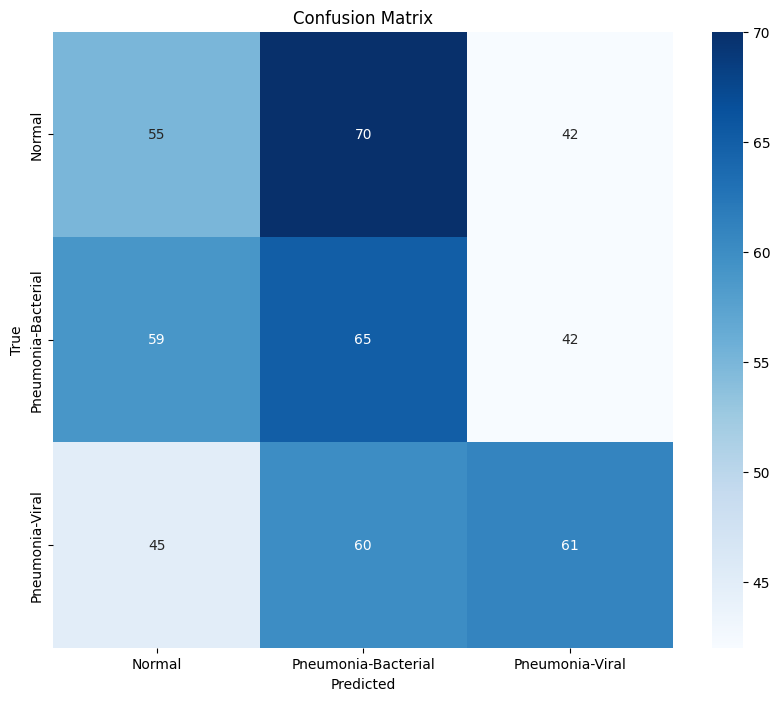


Classification Report:
                     precision    recall  f1-score   support

             Normal       0.35      0.33      0.34       167
Pneumonia-Bacterial       0.33      0.39      0.36       166
    Pneumonia-Viral       0.42      0.37      0.39       166

           accuracy                           0.36       499
          macro avg       0.37      0.36      0.36       499
       weighted avg       0.37      0.36      0.36       499



In [14]:
# Evaluate model
evaluate_model(model, test_generator)